# Deepchem을 활용한 Tox21 분자독성예측 예제

- Deepchem라이브러리를 활용하여 Tox21 데이터세트에 포함된 분자의 독성을 예측해보는 예제
- Deepchem은 텐서플로우 기반으로 신약개발 분야에 활용되는 머신러닝/딥러닝 라이브러리(=패키지)
- 예제를 통하여 머신러닝/딥러닝을 어떻게 실제 세계의 문제에 적용하는지 접근법과 딥러닝 모델의 구체적인 활용법을 이해

In [1]:
import numpy as np
import deepchem as dc
import pickle
import matplotlib.pyplot as plt

2023-11-12 19:37:04.050829: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 19:37:04.186508: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-12 19:37:04.227617: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 19:37:04.962282: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## 데이터 불러오기

In [2]:
# 파일 이름 목록 생성
file_names = [f"./data/tox21_X_part{i}.npy" for i in range(3)]

# 각 파일을 읽어와 리스트에 저장
arrays = [np.load(file) for file in file_names]

# 리스트에 저장된 모든 어레이를 하나로 합침
X = np.concatenate(arrays)

y = np.load('./data/tox21_y.npy')
w = np.load('./data/tox21_w.npy')
ids = np.load('./data/tox21_id.npy', allow_pickle=True)

with open("./data/task.pkl","rb") as f:
    tox21_tasks = pickle.load(f)


## 각 바이오마커의 활성/비활성 분포 확인

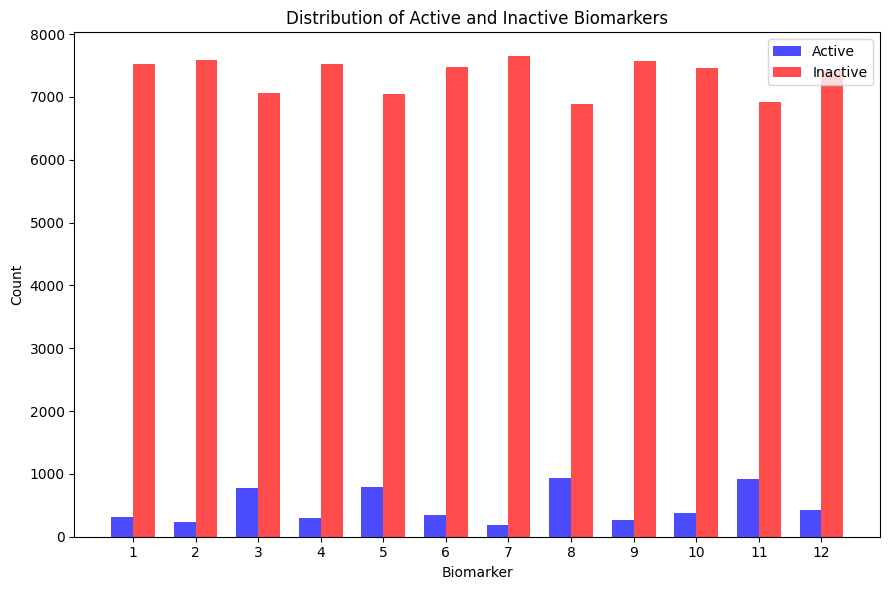

In [3]:
# 각 바이오마커에 대한 활성 여부의 분포를 계산
biomarkers_active_counts = [np.sum(y[:, i] == 1) for i in range(y.shape[1])]
biomarkers_inactive_counts = [np.sum(y[:, i] == 0) for i in range(y.shape[1])]

# 결과를 시각화
bar_width = 0.35
index = np.arange(1, y.shape[1] + 1)

plt.figure(figsize=(9, 6))
plt.bar(index, biomarkers_active_counts, color='b', alpha=0.7, width=bar_width, label='Active')
plt.bar(index + bar_width, biomarkers_inactive_counts, color='r', alpha=0.7, width=bar_width, label='Inactive')

plt.xlabel('Biomarker')
plt.ylabel('Count')
plt.title('Distribution of Active and Inactive Biomarkers')
plt.xticks(index + bar_width / 2, index)
plt.legend()
plt.tight_layout()
plt.show()


## DeepChem DiskDataset으로 변환

In [6]:
tox21_datasets = dc.data.DiskDataset.from_numpy(X=X, y=y, w=w, tasks=tox21_tasks, ids=ids)
tox21_datasets

<DiskDataset X.shape: (7831, 1024), y.shape: (7831, 12), w.shape: (7831, 12), task_names: ['NR-AR' 'NR-AR-LBD' 'NR-AhR' ... 'SR-HSE' 'SR-MMP' 'SR-p53']>

## 데이터 분할

In [7]:
splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(tox21_datasets,
                                                                             frac_train=0.8,
                                                                             frac_valid=0.1,
                                                                             frac_test=0.1)
print('train : ', train_dataset.X.shape, end='\n')
print('valid : ', valid_dataset.y.shape, end='\n')
print('test : ', test_dataset.w.shape, end='\n')


train :  (6264, 1024)
valid :  (783, 12)
test :  (784, 12)


## 데이터 확인
- Task는 아래 12가지 표적 단백질로 구성
- 표적 단백질은 잠재적으로 신약에 활용될 수 있는 분자와 결합시 독성 반응을 보이는 것으로 여겨짐
- tox21_datasets는 train, valid, test의 3가지 데이터셋으로 구성됨
- X벡터 = 학습 또는 추론에 사용할 feature(특징), 각 샘플은 분자의 FingerPrint
- y벡터 = 학습 또는 추론결과인 정답, 참값등, 각 샘플의 레이블 12개는 표적 단백질 12종과의 결합 정도를 의미
- w벡터 = 가중치(weight)값

In [8]:
print('tasks : ', tox21_tasks, end='\n\n')
print('X : ', test_dataset.X, end='\n\n')
print('y : ', test_dataset.y, end='\n\n')
print('w : ', test_dataset.w, end='\n\n')

tasks :  ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']

X :  [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

y :  [[0. 0. 0. ... 0. 1. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 1. 0.]]

w :  [[ 1.04502242  1.03632599  0.         ...  1.05576503  6.7257384
   1.05288369]
 [ 1.04502242 28.52849741  1.12502653 ...  1.05576503  6.7257384
   1.05288369]
 [ 1.04502242  1.03632599  1.12502653 ...  1.05576503  1.17464996
   1.05288369]
 ...
 [ 1.04502242  1.03632599  1.12502653 ...  0.          1.17464996
   1.05288369]
 [ 1.04502242  1.03632599  0.         ...  1.05576503  1.17464996
   1.05288369]
 [ 1.04502242  1.03632599  8.99830221 ...  1.05576503  6.7257384
   1.05288369]]

